# Import and Install Dependencies

In [19]:
!pip install tensorflow==2.4.1 tensorflow-gpu==2.4.1 opencv-python mediapipe sklearn matplotlib

In [8]:
import cv2
import numpy as np
import os
from matplotlib import pyplot as plt
import time
import mediapipe as mp

# Landmark painting Method using MediaPipe Holistic

In [9]:
mp_holistic = mp.solutions.holistic # Holistic model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities

In [10]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [11]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections

In [12]:
def draw_styled_landmarks(image, results):
    # Draw face connections
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS, 
                             mp_drawing.DrawingSpec(color=(80,110,10), thickness=1, circle_radius=1), 
                             mp_drawing.DrawingSpec(color=(80,256,121), thickness=1, circle_radius=1)
                             ) 
    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             ) 
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             ) 
    # Draw right hand connections  
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS, 
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4), 
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             ) 

In [77]:
cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
#         print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)

        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [24]:
draw_styled_landmarks(frame, results)

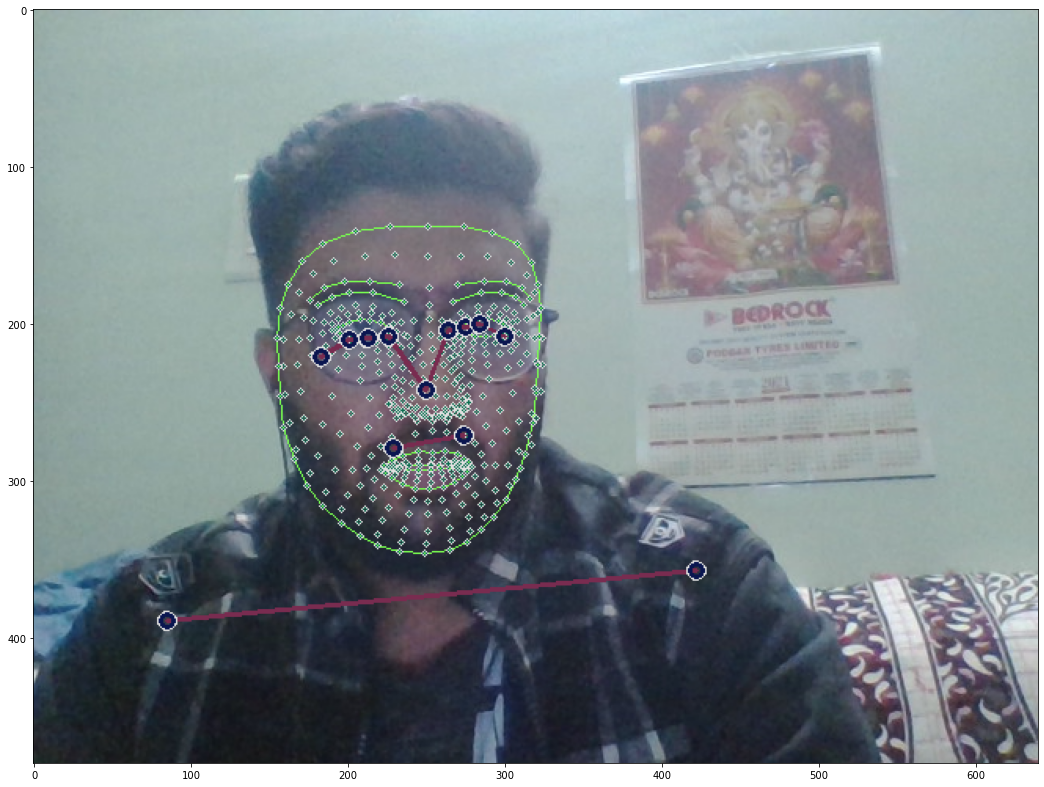

In [25]:
plt.figure(figsize=(18,18))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))

# Extract Keypoint Value Method

In [69]:
len(results.pose_landmarks.landmark)

33

In [70]:
len(results.face_landmarks.landmark)

468

In [71]:
len(results.left_hand_landmarks.landmark)

21

In [72]:
len(results.right_hand_landmarks.landmark)

21

In [13]:
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

# Adding custom gesture

In [14]:
# Path for exported data, numpy arrays
DATA_PATH = os.path.join('Major_Project_Data')

In [15]:
name = input('Enter gesture name: ')

Enter gesture name: i_love_you


In [16]:
# setting number of videos
no_sequences = 30

# setting frame count for each video
sequence_length = 30

In [17]:
#Setting up folders for dataset collection

for sequence in range(no_sequences):
    try:
        os.makedirs(os.path.join(DATA_PATH,name,str(sequence)))
    except:
        pass

In [18]:
# Capturing Videos for gesture training

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    
    
    for sequence in range(no_sequences):
        # Loop through video length aka sequence length
        for frame_num in range(sequence_length):

            # Read feed
            ret, frame = cap.read()

            # Make detections
            image, results = mediapipe_detection(frame, holistic)

            # Draw landmarks
            draw_styled_landmarks(image, results)

            # NEW Apply wait logic
            if frame_num == 0: 
                cv2.putText(image, 'STARTING COLLECTION', (120,200), 
                           cv2.FONT_HERSHEY_SIMPLEX, 1, (0,255, 0), 4, cv2.LINE_AA)
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(name, sequence), (15,12), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', image)
                cv2.waitKey(1000)
            else: 
                cv2.putText(image, 'Collecting frames for {} Video Number {}'.format(name, sequence), (15,12), 
                           cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                # Show to screen
                cv2.imshow('OpenCV Feed', image)

            # NEW Export keypoints
            keypoints = extract_keypoints(results)
            npy_path = os.path.join(DATA_PATH, name, str(sequence), str(frame_num))
            
            # Saving frame keypoints in .npy file
            np.save(npy_path, keypoints)

            # Break
            if cv2.waitKey(10) & 0xFF == ord('q'):
                break
                    
    cap.release()
    cv2.destroyAllWindows()

In [158]:
cap.release()
cv2.destroyAllWindows()

# Label Creation

In [86]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [87]:
actions=[]
for dir in os.listdir(os.path.join(DATA_PATH)):
    actions.append(dir)
actions = np.array(actions)

In [88]:
actions

array(['hello', 'idle', 'thanks'], dtype='<U6')

In [89]:
label_map = {label:num for num, label in enumerate(actions)}

In [90]:
label_map

{'hello': 0, 'idle': 1, 'thanks': 2}

# Sequence Preprocessing, Train-Test Set Splitting

In [91]:
sequences, labels = [], []
for action in actions:
    for sequence in np.array(os.listdir(os.path.join(DATA_PATH, action))).astype(int):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [92]:
np.array(sequences).shape

(90, 30, 1662)

In [93]:
np.array(labels).shape

(90,)

In [94]:
X = np.array(sequences)

In [95]:
X.shape

(90, 30, 1662)

In [96]:
y = to_categorical(labels).astype(int)

In [97]:
# Splitting train and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05, random_state = 1)

In [98]:
y_test.shape

(5, 3)

# Build and Train LSTM Neural Network

In [99]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [100]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [101]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

In [102]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [103]:
model.fit(X_train, y_train, epochs=500, callbacks=[tb_callback])

Epoch 1/500
3/3 [==============================] - 6s 578ms/step - loss: 1.1369 - categorical_accuracy: 0.3307
Epoch 2/500
3/3 [==============================] - 0s 89ms/step - loss: 1.2150 - categorical_accuracy: 0.4305
Epoch 3/500
3/3 [==============================] - 0s 81ms/step - loss: 1.2767 - categorical_accuracy: 0.3913
Epoch 4/500
3/3 [==============================] - 0s 83ms/step - loss: 4.1865 - categorical_accuracy: 0.4443
Epoch 5/500
3/3 [==============================] - 0s 85ms/step - loss: 2.2603 - categorical_accuracy: 0.4265
Epoch 6/500
3/3 [==============================] - 0s 81ms/step - loss: 1.1308 - categorical_accuracy: 0.3308
Epoch 7/500
3/3 [==============================] - 0s 81ms/step - loss: 1.0849 - categorical_accuracy: 0.3445
Epoch 8/500
3/3 [==============================] - 0s 84ms/step - loss: 1.0131 - categorical_accuracy: 0.3249
Epoch 9/500
3/3 [==============================] - 0s 80ms/step - loss: 0.8269 - categorical_accuracy: 0.6909
Epoch 10/

3/3 [==============================] - 0s 88ms/step - loss: 4.5698e-06 - categorical_accuracy: 1.0000
Epoch 144/500
3/3 [==============================] - 0s 86ms/step - loss: 5.0707e-06 - categorical_accuracy: 1.0000
Epoch 145/500
1/3 [=========>....................] - ETA: 0s - loss: 4.6380e-06 - categorical_accuracy: 1.0000

KeyboardInterrupt: 

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 30, 64)            442112    
_________________________________________________________________
lstm_1 (LSTM)                (None, 30, 128)           98816     
_________________________________________________________________
lstm_2 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 64)                4160      
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 2)                 66        
Total params: 596,642
Trainable params: 596,642
Non-trainable params: 0
__________________________________________________

# Checkpoint Manipulation

In [210]:
model.save('action1.h5')

In [135]:
del model

In [194]:
model.load_weights('action.h5')

# Make Predictions

In [198]:
res = model.predict(X_test)

In [199]:
res

array([[1.26976632e-02, 9.86198246e-01, 1.10412040e-03],
       [2.48856827e-06, 1.10211295e-05, 9.99986529e-01],
       [1.66783538e-02, 9.79878664e-01, 3.44296941e-03],
       [1.31344981e-02, 9.85622585e-01, 1.24300318e-03],
       [4.28024532e-06, 1.71565316e-05, 9.99978542e-01]], dtype=float32)

In [200]:
actions[np.argmax(res[2])]

'ok'

In [201]:
actions[np.argmax(y_test[2])]

'ok'

# Evaluation using Confusion Matrix and Accuracy

In [30]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [31]:
yhat = model.predict(X_test)

In [32]:
ytrue = np.argmax(y_test, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [33]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[2, 0],
        [0, 1]],

       [[1, 0],
        [0, 2]]], dtype=int64)

In [34]:
accuracy_score(ytrue, yhat)

1.0

# Practical Application

In [104]:
from scipy import stats

In [105]:
colors = (255,255,255)
def prob_viz(res, actions, input_frame, colors):
    output_frame = input_frame.copy()
    for num, prob in enumerate(res):
        cv2.rectangle(output_frame, (0,60+num*40), (int(prob*100), 90+num*40), colors, -1)
        cv2.putText(output_frame, actions[num], (0, 85+num*40), cv2.FONT_HERSHEY_SIMPLEX, 1, (0,0,0), 2, cv2.LINE_AA)
        
    return output_frame

In [23]:
plt.figure(figsize=(18,18))
plt.imshow(prob_viz(res, actions, image, colors))

NameError: name 'prob_viz' is not defined

<Figure size 1296x1296 with 0 Axes>

In [ ]:
# 1. New detection variables
sequence = []
sentence = []
predictions = []
threshold = 0.99

cap = cv2.VideoCapture(0)
# Set mediapipe model 
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    while cap.isOpened():

        # Read feed
        ret, frame = cap.read()

        # Make detections
        image, results = mediapipe_detection(frame, holistic)
        print(results)
        
        # Draw landmarks
        draw_styled_landmarks(image, results)
        
        # 2. Prediction logic
        keypoints = extract_keypoints(results)
        sequence.append(keypoints)
        sequence = sequence[-30:]
        
        if len(sequence) == 30:
            res = model.predict(np.expand_dims(sequence, axis=0))[0]
            print(actions[np.argmax(res)])
            predictions.append(np.argmax(res))
            
            
        #3. Viz logic
            if np.unique(predictions[-30:])[0]==np.argmax(res): 
                if res[np.argmax(res)] > threshold: 
                    
                    if len(sentence) > 0: 
                        if actions[np.argmax(res)] != sentence[-1]:
                            sentence.append(actions[np.argmax(res)])
                    else:
                        sentence.append(actions[np.argmax(res)])

            if len(sentence) > 5: 
                sentence = sentence[-5:]

            # Viz probabilities
            image = prob_viz(res, actions, image, colors)
            
        cv2.rectangle(image, (0,0), (640, 40), (245, 117, 16), -1)
        cv2.putText(image, ' '.join(sentence), (3,30), 
                       cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
        # Show to screen
        cv2.imshow('OpenCV Feed', image)

        # Break gracefully
        if cv2.waitKey(10) & 0xFF == ord('q'):
            break
    cap.release()
    cv2.destroyAllWindows()

In [43]:
cap.release()
cv2.destroyAllWindows()

In [62]:
res[np.argmax(res)] > threshold

True